# This is a script to read the sequencing results from the first construct (PGM_1.0 repeat) 
### Notebook [started on the 7th April 2017] modified on 11th Oct


The construct has 32 repeats that are a series of Emx1.6 targets with 0-1-2 mismatches from the perfect target site (1-16). 
The same targets are repeated in 17-32 but in this case they have a TAG PAM instead of a TGG.

From the first experiment, it was decided that 2 different targets would be selected, a Fast target and a Slow target.
The Fast target correspond to the target #16 in the construct, which is the "perfect target" (EMx1.6 target).
The slow target is the target #1 in the construct.



#### The construct was tested in 4 different conditions:
-Embryos

-Larva (male and Female)

-Adult (male and Female)

-unmutated target

## Sequencing using amplicons

The “Amplicon” files contain the results of sequencing by PCR.

The repeats were sequenced in triplets, so the first 3 are sequenced in “amplicon 1” and so on..
So the Slow target is contained in “Amplicon 1” and the fast target is contained in “Amplicon 6”.

#### The sequencing primers for the Fast target are:

5' TTGAGAAGATAGACAGAATATGCGC 3'

5' TGAGACCGACCCTGACCTGATG 3'



## Check the mutation rate for the Embryo-Fast

In here, I will only focus on the sequencing of the Fast target of the embryo conditions.

### I will manually correct for what we consider a sequencing error:

#### THE 3' "PRIMER" WILL BE JUST AFTER THE PAM, AND WILL INCLUDE THE POSSIBILITY OF HAVING THE SINGLE NUCLEOTIDE DELETIONS FOUND ON THE UNMUTATED TARGET. These are the 4 posibilities

TGGAGTACTGCTGAGACCGAC

T-GAGTACTGCTGAGACCGAC

TGGAG-ACTGCTGAGACCGAC

T-GAG-ACTGCTGAGACCGAC

### The read should be at least 100 pb to consider it

For the fast target, this is the whole sequenced repeat:

( | primer | target | spacer | primer)

ttgagaagatagacagaatatgcgc gcgccaccggttgatgtgattgg agtactgc tgagaccgaccctgacctgatg

### This is the construct

![PGM_1.0_repeats](PGM_1.0_repeats_small.jpg)



In [1]:
import sys
sys.path.insert(0, "/usr/lib/python3/dist-packages")
sys.path.insert(0, "/home/irepan/software/anaconda3/lib/python3.6/site-packages")
sys.path.insert(0, "/usr/local/lib/python2.7/dist-packages/")
#print('\n'.join(sys.path))

## First, load the packages to use


In [2]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import random
from collections import Counter
random.seed(123)

import matplotlib.pyplot as plt
import numpy as np
import numpy


import math
from matplotlib import gridspec



## Open the amplicon file

As a first step I need to open the file with the results for the "Embryo-Fast". 

This is in the file ('/Barcode-repeat-split/Embryos/Embryos_Amplicon6.txt') found in the dryad repository indicated in the manuscript.

Display the first 6 lines of the file


In [3]:
input_file ='../Barcode-repeat-split/Embryos/Embryos_Amplicon6.txt'
Amplicon6 = open(file= input_file)

for x in range(0,6):
    print("(line %d)" % (x), Amplicon6.readline())
Amplicon6.close()

(line 0) >QP75T:00045:00021

(line 1) TTGAGAAGATAGACAGAATATGCGCGCGCCATTGGTTGATGTGATTAGAGTTCCAGCCCATACCCGATTCAGAGAGAGAGCAGTCCGACTGACGGAATAGACGATGCCACCACCTGAAGCATCGCGCACAAT

(line 2) >QP75T:00010:00094

(line 3) TTGAGAAGATAGACAGAATATGC

(line 4) >QP75T:00012:00070

(line 5) TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATTGGTATCTGCCTGAGACGAGACGAACTGCCTTCCGAAGATGACTGTCAGAGATTAGAGCACCGTACCCGATCCGAAATGTCCGCGCCATTGGTTGATGTGATTAGAGTTCCAGCCCATACCCGATTCAGAGAGAGAGCAGTCCCGACTGACGGAATAGACGATGCCCACCCACCCTGAAGATGCCGCCACCCA



## Upload the primers and define the full construct sequence

In [4]:
primer5 = "TTGAGAAGATAGACAGAATATGCGC"

primer3_1 = "TGGAGTACTGCTGAGACCGA"
Full_1 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGGAGTACTGCTGAGACCGA"

primer3_2 = "TGAGTACTGCTGAGACCGA"
Full_2 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGAGTACTGCTGAGACCGA"

primer3_3 = "TGGAGACTGCTGAGACCGA"
Full_3 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGGAGACTGCTGAGACCGA"

primer3_4 = "TGAGACTGCTGAGACCGA"
Full_4 = "TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGATGTGATTGAGACTGCTGAGACCGA"

target = "TGATGTGAT"
print("my primer 5' is", primer5)

my primer 5' is TTGAGAAGATAGACAGAATATGCGC


## Define a function to find the primers in each amplified sequence

The function takes a line of the file as the input and fisrt check for each base if it matches with the first primer base. If it matches, then looks if the entire primer sequence matches.

Then open the file line by line to search for the primer sequence


In [5]:
## This is the function

def find_Primers(dna,my_p5,my_p3):
    p5=0; p3=0;
    substr = my_p5;
    for p in range(len(dna)):
        if dna[p] == substr[0]:
            if dna[p:p + len(substr)] == substr:
                p5=p
    substr = my_p3;
    for p in range(len(dna)):
        if dna[p] == substr[0]:
            if dna[p:p + len(substr)] == substr:
                p3=p + len(substr)
    return p5, p3


## Read the file and search line by line for the primers

As the file contains the amplified sequence name and then the sequence in the next line read each pair-numbered line (in python would be even-numbered as it starts from 0)

Using the function defined previously, search for both primers. The function returns the location of the most 5' and 3' locations of the primers, so the sequence can be spliced.

### All sequences found, are appended to the list "my_seqs", which will be used for further analysis.
### Find the proportion of Unmutated sequences in "my_seqs" and store it as a variable ("No_mut")



(as a test print the fist 5 sequences found)

In [6]:
Amplicon6 = open(file= input_file)

my_seqs = list()
primer_ends = 0
c=0 

for i, line in enumerate(Amplicon6):
    ## filter out all seqs with length less than 100
    if (i % 2 != 0) and (len(line)>=100):
        
        ## primer 3_1
        primer_ends = find_Primers(line,primer5,primer3_1)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_1)
            if x >= 0: c = c+1
        ## primer 3_2
        primer_ends = find_Primers(line,primer5,primer3_2)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_2)
            if x >= 0: c = c+1
        ## primer 3_3
        primer_ends = find_Primers(line,primer5,primer3_3)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_3)
            if x >= 0: c = c+1
        ## primer 3_4
        primer_ends = find_Primers(line,primer5,primer3_4)
        if primer_ends != (0,0) :
            s = line[primer_ends[0]:primer_ends[1]]
            my_seqs.append(s); x = s.find(Full_4)
            if x >= 0: c = c+1
            
                
No_mut = c/len(my_seqs)
            
Amplicon6.close()

for i in range(1): print("line",i+1, my_seqs[i])

print("\nNumber of unmutated targets =",c,"  proportion is %.4g" % (No_mut))
print("\nTotal number of targets is ", len(my_seqs))


line 1 TTGAGAAGATAGACAGAATATGCGCGCGCCACCGGTTGGTGATTGGAGTACTGCTGAGACCGA

Number of unmutated targets = 1313   proportion is 0.1161

Total number of targets is  11311


In [7]:
#out1 = open("my_seqs.txt","w") 
#for index, item in enumerate(my_seqs): 
#    out1.write(my_seqs[index])
#    out1.write("\n")
#out1.close()


## Define a function to search for the position of the primer

#### The output of the function is the first nucleotide of the seq primer. This will be used to read the Nmers


In [8]:
def find_target(dna,myprimer3):
    sub = None
    substr = myprimer3
    for p in range(len(dna)):
        if dna[p] == substr[0]:
            if dna[p:p + len(substr)] == substr:
                sub=p
    return sub

# Get all possible sequences from the sequencing primer if you read 9bp from the 3' primer

This is to know how many different deletions we have, and what is their distribution (e.g., is there one copy that is found in 25% of the sequences?


In [9]:
Nmer_pb = 9 ## Number of nucleotides in the target
N_unique = 0;
c= 0;
Nmer_LIST=list();
## Search in all amplified sequences:
for s in range(len(my_seqs)):
    seq = my_seqs[s]
    # primer 3_1
    x = find_target(seq,primer3_1)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])
    # primer 3_2
    x = find_target(seq,primer3_2)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])
    # primer 3_3
    x = find_target(seq,primer3_3)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])
    # primer 3_4
    x = find_target(seq,primer3_4)
    if x != None:             # if the primer can be found in the amplified sequence
        c = c + 1; Nmer_LIST.append(seq[x-Nmer_pb:x])

UniqueNmers = set(Nmer_LIST)
N_unique = len(UniqueNmers)

Nmer_TOTALS = c;
print("number of Nmers:", len(UniqueNmers), "total:", Nmer_TOTALS,"\n") 
#print(c, N_unique, UniqueNmers)


number of Nmers: 237 total: 11311 



In [10]:
out2 = open("Fast_Embryo_ALL_Nmers.txt","w") 

for cm in range(len(Nmer_LIST)) : 
    out2.write(Nmer_LIST[cm])
    out2.write("\n")
out2.close()

# Get the frequency of each of the Nmers for all the sites
### Use the unmutated proportion of targets as a reference. The ideal would be to have the lowest possible frequency of the "unmutated" Nmer, and that get many mutated Nmers at a frequency that is informative

In [11]:
Sorted_Lists_Vals = list()
Sorted_Lists_Labs = list()
Original_Nmers = list()

Unique_Nmer_freq= list()

### Get the real Nmer
Nmer_seq = target

UniqueList = list(UniqueNmers)
#print("for ", "distance:", len(UniqueList), "\n") 

## The Nmer_List contains all Nmers, search the frequency of each unique Nmer (uniques are in UniqueList)
Nmer_freq=list()
for i in range(len(UniqueList)):
    Unique_Nmer_freq.append([UniqueList[i],
                  #           '{:04d}'.format(Nmer_LIST.count(UniqueList[i]))]
                             Nmer_LIST.count(UniqueList[i])])
    #print(Unique_Nmer_freq)
Sorted_Unique = sorted(Unique_Nmer_freq, key=lambda Unique_Nmer_freq: Unique_Nmer_freq[1])
Sorted_Unique_labs = [item[0] for item in Sorted_Unique]
Sorted_Unique_vals = [item[1] for item in Sorted_Unique]

Sorted_Lists_Vals.append(Sorted_Unique_vals)
Sorted_Lists_Labs.append(Sorted_Unique_labs)
   
print(Sorted_Lists_Vals)
#print(Sorted_Lists_Labs)


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 9, 11, 11, 12, 13, 14, 15, 15, 18, 20, 20, 22, 22, 23, 23, 23, 25, 28, 29, 29, 30, 30, 31, 31, 34, 34, 34, 34, 36, 38, 40, 41, 41, 41, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 48, 51, 51, 62, 62, 66, 80, 90, 91, 112, 122, 131, 156, 160, 248, 256, 284, 297, 315, 329, 346, 401, 430, 450, 500, 528, 1350, 2687]]


## Plot all the Nmer freqs 

In the plot below, the frequency (Yaxis) of each Nmer (Xaxis) is shown. The Nmers are sorted from low to high frequency to see ir more clearly. In red we can see the proportion of Nmers with a sequence equal to the "unmutated" Nmer (Could be the unmutated or not).
As a dashed vertical line, we can see the real proportion of unmutated sequences.

Freq of the most common Nmer: 0.238 	 the unmutated total: 1350 proportion : 0.11935


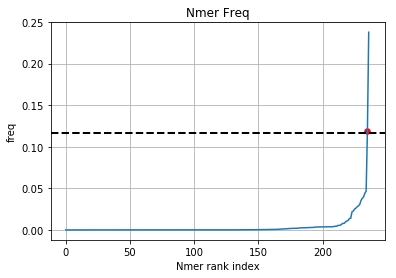

In [12]:
Vals = Sorted_Lists_Vals[0]
    
Labs = Sorted_Lists_Labs[0]
    
Rel_Vals = list()
for index, item in enumerate(Vals):
    Rel_Vals.append(Vals[index]/Nmer_TOTALS)
        
plt.plot(Rel_Vals)
plt.xlabel('Nmer rank index')
plt.ylabel('freq')
plt.title('Nmer Freq')
plt.grid(True)
#plt.axvline(x=Nmer90, ymin=0, ymax=1,linewidth=1, c='black', hold=None,linestyle="dashed")

plt.axhline(y=No_mut, xmin=0, xmax=1,linewidth=2, c='black', hold=None,linestyle="dashed")
## plot the sequence that is the same as the unmutated one
for index, item in enumerate(Labs):
    if item == target:
        #ax.annotate(Nmer,(index,Vals[index]), size = 14,color = "r")
        plt.scatter(index,Rel_Vals[index],s=30,c="r")
        if Rel_Vals[index] < 1 :
            print("Freq of the most common Nmer: %.3g" % (max(Vals)/Nmer_TOTALS),
                  "\t the unmutated total:", Vals[index],"proportion : %.5g" % (Vals[index]/Nmer_TOTALS) )

ax = plt.gca()

plt.show()


## Barcode for SOLiD sequencing

The different combinations of Nmers can be used to make "extended primers", starting at position 3 (as explained above) together with the Nmer.
The ideal would be to generate these extended primers together with a barcode so that the barcode is read as a color with SOLiD sequencing.
As we know the frequencies of each Nmer, we can assign the barcodes to each of them so the color frequencies are homogeneous.
Importantly, we would ignore the unmutated Nmer, so the "blank" read would be as a fifth color state.

For the barcode assignement we should the consider how many of the Nmers we would like to use, because is not practical to produce >200 primers if most of them would only would appear with a probability of >0.001 (for example).


In [13]:
Tot_Nmers = None        ## this variable will have the total number of Nmers, after removing the unmutated ones
#print("original Nmer = ", Nmer)

## To delete the unmutated sequences from the lists and calculate the new total number of Nmers
for index, item in enumerate(Labs):
        if item == target:
            Tot_Nmers = Nmer_TOTALS - Vals[index]
            #print("New number of total nmers =", Tot_Nmers)
            del Vals[index]
            del Labs[index]

for index, item in enumerate(Vals):
        Vals[index] = (Vals[index]/Tot_Nmers)

#### Plot the cumulative probability of all the Nmers, after removing the unmutated sequences

to get 90% we need at least 42 Nmers
to get 95% we need at least 59 Nmers
to get 99% we need at least 137 Nmers


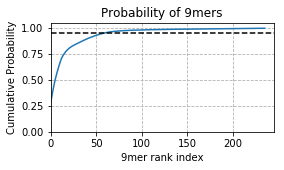

In [14]:
plt.figure(figsize=(4,2))
cumulative = np.cumsum( sorted(Vals, reverse=True))
plt.plot(cumulative)
Nmer90 = None
Nmer95 = None
Nmer99 = None
for index, item in enumerate(cumulative):
    if item >= 0.90 and Nmer90 == None:
            print ("to get 90% we need at least", index+1, "Nmers")
            Nmer90 = index+1
    if item >= 0.95 and Nmer95 == None:
            print ("to get 95% we need at least", index+1, "Nmers")
            Nmer95 = index+1 
    if item >= 0.99 and Nmer99 == None:
            print ("to get 99% we need at least", index+1, "Nmers")
            Nmer99 = index+1

plt.xlabel('9mer rank index')
plt.ylabel('Cumulative Probability')
plt.title('Probability of 9mers')
plt.grid(True,axis='both', linestyle= 'dashed')
#plt.axvline(x=Nmer90, ymin=0, ymax=1,linewidth=1, c='black', hold=None,linestyle="dashed")
#plt.axvline(x=Nmer95, ymin=0, ymax=1,linewidth=1.5, c='black', hold=None,linestyle="dashed")
plt.axhline(y=0.95, xmin=0, xmax=1,linewidth=1.5, c='black', hold=None,linestyle="dashed")
#plt.axvline(x=Nmer99, ymin=0, ymax=1,linewidth=2, c='black', hold=None,linestyle="dashed")

ax = plt.gca()
ax.set_ylim([0,1.05])
ax.set_xlim([0,245])

plt.savefig("9mer_Cumprob.svg")
plt.show()

### Discusion:
#### From the results, it seems that we could use 59 Nmers to make primers, as with that number we would recover 95% of the deletions. Now, the "colors" or 4 different states should be assigned to each Nmer, so that in total, the probability for each color is more or less the same. One color would be assigned only to the most common Nmer, which has a probability of > 0.25. The rest of the Nmers would be assigned a color trying to have them in equal probabilities


In [15]:
ii = len(Vals)-1

c = 1
cc= 1
t = 0.95
nc = 4

## Make a list for each color, of all the barcodes that will be associated to it, so we have uniform freqs
B_probs = list()
G_probs = list()
Y_probs = list()
R_probs = list() 

all_C = numpy.zeros(4) # Here I will store the cumulative probability of each color

for i in range(Nmer95):
    
    if c > 4 : c = cc
    if c == 1 : B_probs.append(str(Labs[ii-i]) + str("\t") + str('{0:.4f}'.format(Vals[ii-i])))
    if c == 2 : G_probs.append(str(Labs[ii-i]) + str("\t") + str('{0:.4f}'.format(Vals[ii-i])))
    if c == 3 : Y_probs.append(str(Labs[ii-i]) + str("\t") + str('{0:.4f}'.format(Vals[ii-i])))
    if c == 4 : R_probs.append(str(Labs[ii-i]) + str("\t") + str('{0:.4f}'.format(Vals[ii-i])))
    
    all_C[c-1] = all_C[c-1] + Vals[ii-i]
    
    #print("Color", c, "Barcode", Labs[ii-i], Vals[ii-i], all_C[c-1], "total", t, "max prop = ", t/nc )
    
    if all_C[c-1] >= t/nc and nc >= 1:
        print("Cum Prob of color", c, "is", all_C[c-1])    
        t = t - all_C[c-1]
        nc = nc-1
        cc = cc + 1
    c= c+1
#print(all_C)
#print(Y_probs)

Cum Prob of color 1 is 0.269752032928
Cum Prob of color 2 is 0.227587591607
Cum Prob of color 3 is 0.227587591607
Cum Prob of color 4 is 0.226884850919


### Plot the cumulative probability for each color and the number of Nmers assigned to each

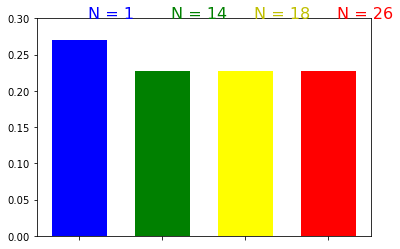

In [16]:
width = 1/1.5
x = np.arange(len(all_C))
plt.bar( x, all_C, width, color=["blue", "green", "yellow", "red"])

ax = plt.gca()
ax.set_ylim([0,0.3])


plt.xticks(x,"")

ax.annotate("N = %d"% (len(B_probs)),(0.1,0.3), size = 16,color = "b")
ax.annotate("N = %d"% (len(G_probs)),(1.1,0.3), size = 16,color = "g")
ax.annotate("N = %d"% (len(Y_probs)),(2.1,0.3), size = 16,color = "y")
ax.annotate("N = %d"% (len(R_probs)),(3.1,0.3), size = 16,color = "r")

plt.show()

### Write into a file the list for all Nmers assigned to each color for the SOLiD sequencing

In [17]:
out = open("Fast_Embryo_SeqError_corrected_Nmers.txt","w") 
 
out.write("COLOR\t" + "Nmer\t" + "Freq\n")
for index, item in enumerate(B_probs): 
    out.write("BLUE" + str("\t") + B_probs[index])
    out.write("\n")
#out.write("\n>GREEN\n")
for index, item in enumerate(G_probs): 
    out.write("GREEN" + str("\t") + G_probs[index])
    out.write("\n")
#out.write("\n>YELLOW\n")
for index, item in enumerate(Y_probs): 
    out.write("YELLOW" + str("\t") + Y_probs[index])
    out.write("\n")
#out.write("\n>RED\n")
for index, item in enumerate(R_probs): 
    out.write("RED" + str("\t") + R_probs[index])
    out.write("\n")
out.close()

# I can perform a simulation with the following parameters based on the analysis:

#### Probability of a mutation (After N cell cycles):
OBSERVED IN TOTAL CONSTRUCT (1 - unmutated proportion) = 1- 0.1161 = 0.8839 

APROXIMATION USING NMERS    (1- unmutated Nmer )      = 1 - 0.11935 
####                                    Mu_rate = 0.88065

## SEQ ERROR CORRECTION (from Fast_Untargeted_Seq_Error_Correction)

Corrected Mu_rate = Unmutated - Seq_Error = 0.88065 - 0.0111 
#### Corrected Mu_rate = 0.86955


## Number of Nmers (10pb) after primer position to get 95% of the deletions:
59

## Probability of each Nmer, from the exported file


## Mutation rate per cell division (from Fast_sequence_Embryo_Mutation_Rate:

From the plot we can establish the mutation rate necessary to produce the observed deletions.

As we are not sure of when the deletions start (one possibility is around cell division 4-5, when the Maternal Zygotic transition begins), I will simulate different number of cell divisions:




|  Cell Cycle  | Mutation Rate  |
|--------------|----------------|
|     11       |      0.169     |
|     12       |      0.156     |
|     13       |      0.145     |
|     14       |      0.1355    |
|     15       |      0.127     |
|     16       |      0.1195    |
|     17       |      0.113     |

